## Load MNIST

All the datasets are provided as zip archives. Each archive contains two files -- a training (and validation) set and a test set. We used the last 2000 examples of the training sets as validation sets and, in the case of SVMs, retrained the models with the entire set after choosing the optimal parameters on these validation sets. Data is stored at one example per row, the features being space-separated. There are 784 features per example (=28*28 images), corresponding to the first 784 columns of each row. The last column is the label, which is 0 to 9.

In [1]:
import numpy as np

In [2]:
def load_binarized_mnist(path):
    # rotated
    #train_x = np.loadtxt(path + "mnist_all_rotation_normalized_float_train_valid.amat")
    #test_x = np.loadtxt(path + "mnist_all_rotation_normalized_float_test.amat")

    # mnist
    train_x = np.loadtxt(path + "mnist_train.amat")
    test_x = np.loadtxt(path + "mnist_test.amat")
    return train_x, test_x

In [3]:
train_x, test_x = load_binarized_mnist("../../data/MNIST/mnist/")
#train_x, test_x = load_binarized_mnist("../../data/rotatedMNIST/mnist_rotation_new/")

In [4]:
train_x.shape, type(train_x), test_x.shape

((12000, 785), numpy.ndarray, (50000, 785))

-----

## set args

In [5]:
import torch

In [6]:
from tensorboardX import SummaryWriter

class Args():
    gpu_id = 0
    max_len = 10000
    zsize=128
    logdir = "mnist_margin01_data10k"
    model_name = "test_mninst"
    device = torch.device("cuda:" + str(gpu_id) if torch.cuda.is_available() else "cpu")
    data_dir = "../../data/MNIST/mnist/"
#    data_dir = "../../data/rotatedMNIST/mnist_rotation_new/"

args = Args()
writer = SummaryWriter(log_dir="../log/tensorboard/" + args.logdir)


---

## define model

In [7]:
from models.worm2vec_non_sequential import Worm2vec_nonseq
import config

In [8]:
# model
model = Worm2vec_nonseq(zsize=args.zsize)

In [9]:
# ここから実行する場合
model.load_state_dict(torch.load("../models/" + args.model_name + ".pkl"))
model.to(args.device)

Worm2vec_nonseq(
  (enc): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): MaxPool2d(kernel_size=2, stride=2, padd

---

In [10]:
import time

## reshape data

In [11]:
from PIL import Image

def reshape_size(img, size, interpolation=Image.NEAREST):
    def resize_img(img):
        img = Image.fromarray(np.uint8(img), mode="L")
        img = img.resize(size, interpolation)
        img = np.asarray(img)
        return img

    resized_img = np.zeros((img.shape[0], size[0], size[1]))

    for i in range(img.shape[0]):
        resized_img[i, :, :] = resize_img(img[i, :, :])
    return resized_img

def normalize(img, max_value=255):
    return (img - img.min()) / (img.max() - img.min()) * max_value


In [12]:
train_x.min(), train_x.max(), test_x.min(), test_x.max()

(0.0, 9.0, 0.0, 9.0)

In [13]:
# Cut
train_x, test_x = train_x[:args.max_len], test_x[:args.max_len]

# Init
train_X = np.zeros((train_x.shape[0], 28, 28))
test_X = np.zeros((test_x.shape[0], 28, 28))
train_labels = []
test_labels = []

for i, (tr_x, te_x) in enumerate(zip(train_x, test_x)):
    train_X[i, :, :] = np.reshape(tr_x[:-1], (28, 28))
    test_X[i, :, :] = np.reshape(te_x[:-1], (28, 28))
    train_labels.append(tr_x[-1])
    test_labels.append(te_x[-1])

# Normalize
train_X = normalize(train_X, 255)
test_X = normalize(test_X, 255)

# Reshape (N, 28, 28) into (N, 64, 64)
train_X = reshape_size(train_X, (64, 64))
test_X = reshape_size(test_X, (64, 64))

print(train_X.shape, test_X.shape)

# Reshape (N, H, W) into (N, i, H, W)
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1], train_X.shape[2]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1], test_X.shape[2]))

# ToTensor
train_X = torch.from_numpy(train_X).type(torch.float)
test_X = torch.from_numpy(test_X).type(torch.float)

# To GPU
train_X = train_X.to(args.device)
test_X = test_X.to(args.device)

print(train_X.shape, test_X.shape)

(10000, 64, 64) (10000, 64, 64)
torch.Size([10000, 1, 64, 64]) torch.Size([10000, 1, 64, 64])


## embed data

In [14]:
def embedding(model, x):
    embed_x = model.encode(x)
    embed_x = model.m_original(embed_x)
    return embed_x

embed_train_X = embedding(model, train_X)
embed_test_X = embedding(model, test_X)

In [15]:
print("input : ", embed_train_X.shape, embed_test_X.shape)
print("output: ", len(train_labels), len(test_labels))

input :  torch.Size([10000, 64]) torch.Size([10000, 64])
output:  10000 10000


---

## test image plot

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

0 torch.Size([1, 64, 64]) torch.Size([1, 64, 64]) 5.0 7.0


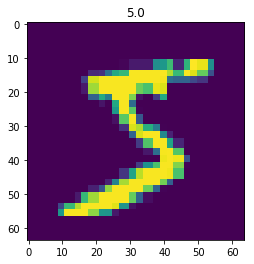

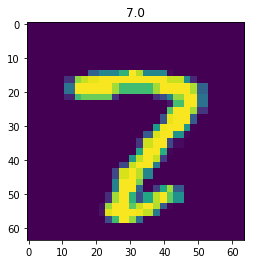

1 torch.Size([1, 64, 64]) torch.Size([1, 64, 64]) 0.0 4.0


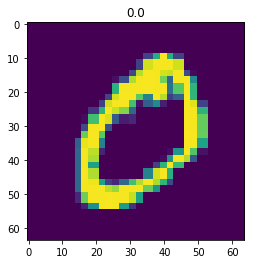

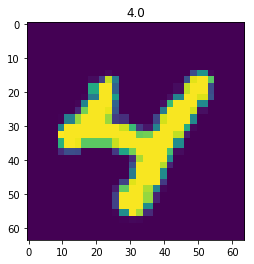

2 torch.Size([1, 64, 64]) torch.Size([1, 64, 64]) 4.0 6.0


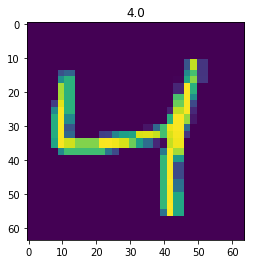

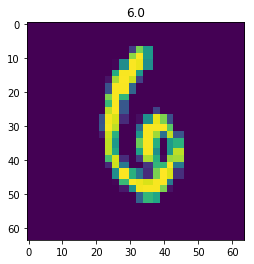

In [18]:
# mnist
for i in range(train_X.shape[0]):
    tr, te = train_X[i].cpu(), test_X[i].cpu()
    tr_label, te_label = train_labels[i], test_labels[i]

    print(i, tr.shape, te.shape, tr_label, te_label)

    plt.imshow(np.asarray(tr[0]))
    plt.title(tr_label)
    plt.show()

    plt.imshow(np.asarray(te[0]))
    plt.title(te_label)
    plt.show()
    
    if i > 1:
        break

---

## train

In [35]:
!pip install seaborn

    100% |################################| 225kB 5.3MB/s ta 0:00:01
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Skip RBF SVM
Skip Linear SVM
------------
Start K Nearest Neighbors
Accuracy:  0.4352


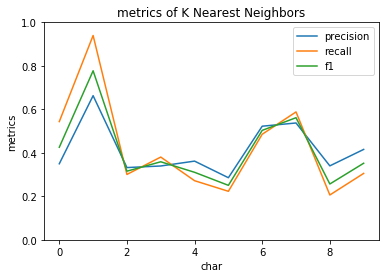

cm: 
[[ 535   23   44   85   39   63   78   29   59   29]
 [   8 1089    4    9    3   10    5   16    9    6]
 [ 144   61  287  112   70   51   61   56   61   52]
 [ 155   53  102  406   39  115   30   61   52   54]
 [ 124   90   90   78  262   47   65   84   38   86]
 [ 167   34   81  179   36  201   39   52   52   60]
 [ 138   43   62   39   65   29  466   23   68   27]
 [  45  100   61   42   35   43   12  591   13   63]
 [ 141   74   60  143   68   80  102   47  202   63]
 [  73   76   73  103  107   65   34  141   40  313]]


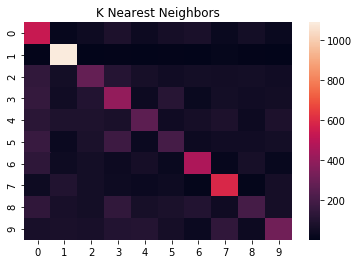

Skip Decision Tree
------------
Start Random Forest
Accuracy:  0.3104


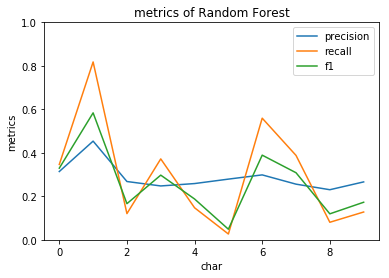

cm: 
[[341  44  44 139  48   9 218  86  24  31]
 [  7 948   6  55  12   3  70  40   9   9]
 [ 78 143 115 168  69   4 157 143  24  54]
 [110 127  34 397  40  13 105 168  33  40]
 [ 57 169  63 103 142   6 212 112  40  60]
 [124  91  53 234  38  24  78 184  33  42]
 [100  74  34  71  32   9 537  34  40  29]
 [ 71 203  26 115  38   3  85 390  22  52]
 [103 133  26 169  58  11 215 142  79  44]
 [ 95 157  28 152  72   4 122 225  39 131]]


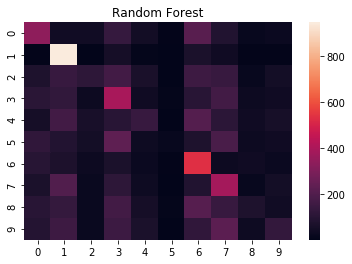

------------
Start Neural Net


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy:  0.3085


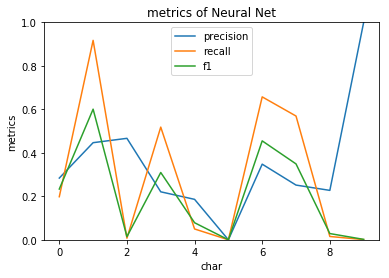

cm: 
[[ 195   59    2  322   38    0  286   76    6    0]
 [   1 1063    0   23    3    0   30   37    2    0]
 [  62  145    7  242   41    0  161  295    2    0]
 [  84   97    1  553    7    0   71  248    6    0]
 [  52  194    2  194   48    0  201  265    8    0]
 [  82  104    0  443   13    0   65  189    5    0]
 [  63  109    1   81   25    0  631   40   10    0]
 [  33  248    0   97   14    0   40  572    1    0]
 [  67  176    0  291   35    0  239  157   15    0]
 [  48  185    2  260   34    0   90  394   11    1]]


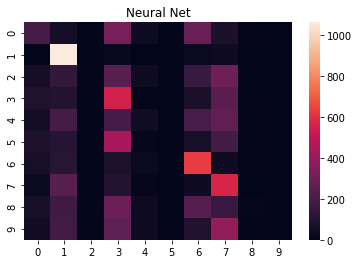

------------
Start AdaBoost
Accuracy:  0.351


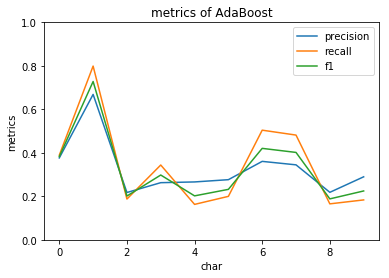

cm: 
[[383  12  65 121  39  63 134  58  76  33]
 [  9 926  22  30  19  11  55  49  23  15]
 [ 73  63 179 136  61  50 142 156  51  44]
 [ 92  37  98 367  40 115  69 102  77  70]
 [ 90  65 107 114 157  41 112 123  81  74]
 [ 93  28  80 216  29 180  72  88  71  44]
 [121  37  48  47  52  27 484  29  83  32]
 [ 31 107  61  70  58  38  34 484  38  84]
 [ 84  53  90 152  52  65 169  88 162  65]
 [ 41  57  73 144  83  61  71 227  80 188]]


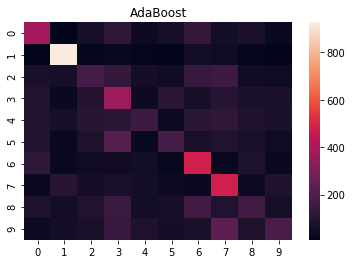

------------
Start Naive Bayes
Accuracy:  0.3941


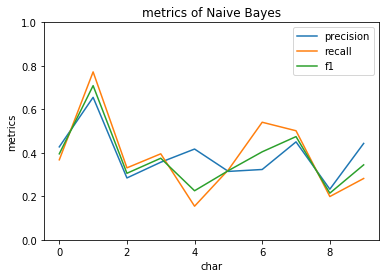

cm: 
[[362  10  82 108  23  94 149  33  89  34]
 [  6 895   5  32   4  19 143  32  18   5]
 [ 55  41 316 122  30  56 129  92  64  50]
 [ 67  42 103 422  19 138  68  86  86  36]
 [ 40  86 157  73 149  50 170  81  78  80]
 [ 87  43 100 136  18 290  55  71  71  30]
 [ 90  27  92  28  27  46 519  12  97  22]
 [ 30 115  56  47  15  33  93 504  54  58]
 [ 67  54 110 106  25 126 181  68 195  48]
 [ 43  53  90 109  47  70  98 140  86 289]]


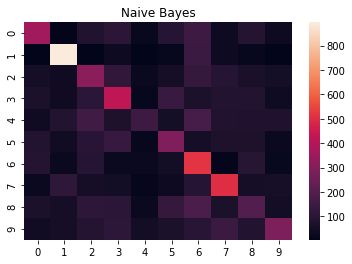

------------
Start QDA
Accuracy:  0.6134


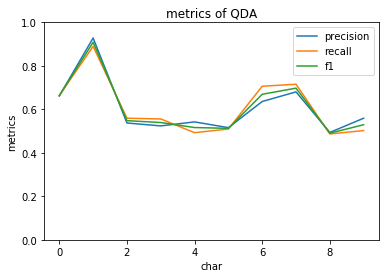

cm: 
[[ 653    0   45   53   34   44   65   11   57   22]
 [   8 1031   22   13   17    5   14   17   20   12]
 [  30   10  534   82   49   42   69   34   74   31]
 [  46   13   66  593   40  120   26   45   78   40]
 [  46   17   71   48  475   36   69   41   57  104]
 [  61    7   38  136   30  459   26   29   76   39]
 [  69    5   67   18   34   20  678    4   47   18]
 [   7   14   41   46   35   22   16  719   19   86]
 [  43    9   66   89   55   89   69   29  477   54]
 [  24    5   44   54  107   53   34  128   61  515]]


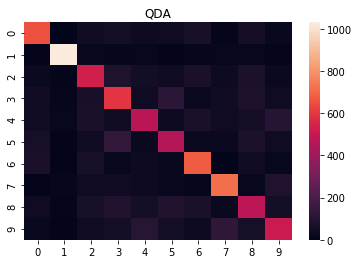

In [64]:
from sklearn import svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import seaborn as sns

names = ["RBF SVM",
         "Linear SVM",
         "K Nearest Neighbors",
         "Decision Tree",
         "Random Forest",
         "Neural Net",
         "AdaBoost",
         "Naive Bayes",
         "QDA"
        ]

classifiers = [svm.SVC(gamma=0.001),
               svm.SVC(kernel="linear", C=0.001),
               KNeighborsClassifier(5),
               DecisionTreeClassifier(max_depth=5),
               RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
               MLPClassifier(alpha=1, max_iter=1000),
               AdaBoostClassifier(),
               GaussianNB(),
               QuadraticDiscriminantAnalysis()
              ]

skip_classifier_name = ["RBF SVM", "Linear SVM", "Decision Tree"]

for (classifier, name) in zip(classifiers, names):

    if name in skip_classifier_name:
        print("Skip " + name)
        continue

    print("------------")
    print("Start " + name)

    classifier.fit(embed_train_X.cpu().detach().numpy(), train_labels)

    predicted = classifier.predict(embed_test_X.cpu().detach().numpy())

    # eval
    cm = metrics.confusion_matrix(test_labels, predicted)
    accuracy = metrics.accuracy_score(test_labels, predicted)
    precision = metrics.precision_score(test_labels, predicted, average=None)
    recall = metrics.recall_score(test_labels, predicted, average=None)
    f1 = metrics.f1_score(test_labels, predicted, average=None)

    print("Accuracy: ", accuracy)
    plt.plot(precision, label="precision")
    plt.plot(recall, label="recall")
    plt.plot(f1, label="f1")
    plt.ylabel("metrics")
    plt.xlabel("char")
    plt.ylim(0, 1.0)
    plt.legend()
    plt.title("metrics of " + name)
    plt.show()

    print("cm: ")
    print(cm)

    sns.heatmap(cm)
    plt.title(name)
    plt.show()

---

In [54]:
writer.close()